<a href="https://colab.research.google.com/github/giuliocapecchi/LM-project/blob/main/unstructured_nougat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/giuliocapecchi/LM-project/blob/main/unstructured_nougat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install torch huggingface_hub python-dotenv transformers sentence-transformers pymupdf langchain langchain-community langchain-huggingface chromadb tqdm unidecode gradio bitsandbytes seaborn

  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
Using cached aiofiles-23.2.1-py3-none-any.whl (15 kB)
  Attempting uninstall: aiofiles
    Found existing installation: aiofiles 24.1.0
    Uninstalling aiofiles-24.1.0:
      Successfully uninstalled aiofiles-24.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unstructured-client 0.28.1 requires aiofiles>=24.1.0, but you have aiofiles 23.2.1 which is incompatible.


In [2]:
!pip install -q pymupdf python-Levenshtein nltk
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!apt-get install poppler-utils tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [4]:
!pip install unstructured[pdf]

  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
Using cached aiofiles-24.1.0-py3-none-any.whl (15 kB)
  Attempting uninstall: aiofiles
    Found existing installation: aiofiles 23.2.1
    Uninstalling aiofiles-23.2.1:
      Successfully uninstalled aiofiles-23.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.9.1 requires aiofiles<24.0,>=22.0, but you have aiofiles 24.1.0 which is incompatible.


In [5]:
import os
import torch
from huggingface_hub import login
from dotenv import load_dotenv
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from sentence_transformers import SentenceTransformer
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
import time
from tqdm import tqdm
import re
import gradio as gr
from unidecode import unidecode
import random

In [6]:
import nltk

print(nltk.__version__)  # confirm you see 3.9.1, otherwise restart session

nltk.download("punkt")

3.9.1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
#!wget -O local_copy.pdf https://arxiv.org/pdf/1706.03762.pdf

In [8]:
PDF_NAME = "IR Slides v1.0.pdf"
running_on_colab = False

try:
    import gdown
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("Running in Google Colab. Using userdata to get HF_TOKEN.")
    # save locally from https://drive.google.com/file/d/1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY/view?usp=drive_link
    gdown.download(id="1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY", output=PDF_NAME, quiet=False)
    gdown.download(id="17eXYgmiTL9-f9F5vIT5j7QffHIu_QwuN", output="elements.pkl", quiet=False)
    # cutted version: https://drive.google.com/file/d/1rO-Egw84aKTK-534CIm4Qpmy5ehehyaM/view?usp=drive_link
    #gdown.download(id="1rO-Egw84aKTK-534CIm4Qpmy5ehehyaM", output=PDF_NAME, quiet=False)
    running_on_colab = True
except ModuleNotFoundError:
    load_dotenv()
    HF_TOKEN = os.getenv('HF_TOKEN')
    print("Not running in Google Colab. Using load_dotenv to get HF_TOKEN.")

file_path = PDF_NAME
login(token=HF_TOKEN)

Running in Google Colab. Using userdata to get HF_TOKEN.


Downloading...
From: https://drive.google.com/uc?id=1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY
To: /content/IR Slides v1.0.pdf
100%|██████████| 85.5M/85.5M [00:03<00:00, 24.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=17eXYgmiTL9-f9F5vIT5j7QffHIu_QwuN
To: /content/elements.pkl
100%|██████████| 1.53M/1.53M [00:00<00:00, 37.3MB/s]


In [9]:
from unstructured.partition.auto import partition

file_name = "IR Slides v1.0.pdf"

title = "Information Retrival"
'''elements = partition(
    filename=file_name,
    strategy="hi_res",
    skip_infer_table_types=[],
    include_page_breaks=True,
)'''

'elements = partition(\n    filename=file_name,\n    strategy="hi_res",\n    skip_infer_table_types=[],\n    include_page_breaks=True,\n)'

In [10]:
# save elements on a binary file
import pickle
'''with open('elements.pkl', 'wb') as f:
    pickle.dump(elements, f)'''

"with open('elements.pkl', 'wb') as f:\n    pickle.dump(elements, f)"

In [11]:
# load elements.pkl in elements
with open('elements.pkl', 'rb') as f:
    elements = pickle.load(f)

In [44]:
type_value_elements = []

for i in range(len(elements)):
  pair = [type(elements[i]), elements[i].text]
  type_value_elements.append(pair)

# print type_value_elements as a table
import pandas as pd
df_elements = pd.DataFrame(type_value_elements, columns=['Type', 'Value'])

# drop all the rows with Type == Image
df_elements = df_elements[df_elements['Type'] != Image]

print(df_elements)


                                                   Type  \
0       <class 'unstructured.documents.elements.Title'>   
1       <class 'unstructured.documents.elements.Title'>   
2     <class 'unstructured.documents.elements.EmailA...   
3     <class 'unstructured.documents.elements.PageBr...   
4       <class 'unstructured.documents.elements.Title'>   
...                                                 ...   
4481  <class 'unstructured.documents.elements.ListIt...   
4482  <class 'unstructured.documents.elements.ListIt...   
4483  <class 'unstructured.documents.elements.ListIt...   
4484   <class 'unstructured.documents.elements.Footer'>   
4485  <class 'unstructured.documents.elements.PageBr...   

                                                  Value  
0                                Multimedia Information  
1                         Retrieval and Computer Vision  
2                            nicola.tonellotto@unipi.it  
3                                                        
4

In [47]:
# print all the different possible Type in the dataframe
print(df_elements['Type'].unique())

[<class 'unstructured.documents.elements.Title'>
 <class 'unstructured.documents.elements.EmailAddress'>
 <class 'unstructured.documents.elements.PageBreak'>
 <class 'unstructured.documents.elements.ListItem'>
 <class 'unstructured.documents.elements.NarrativeText'>
 <class 'unstructured.documents.elements.FigureCaption'>
 <class 'unstructured.documents.elements.Table'>
 <class 'unstructured.documents.elements.Text'>
 <class 'unstructured.documents.elements.Footer'>
 <class 'unstructured.documents.elements.Formula'>
 <class 'unstructured.documents.elements.Header'>]


In [54]:
from unstructured.documents.elements import EmailAddress, FigureCaption, Table, Footer, Header

#print(len(df_elements[df_elements['Type'].isin([EmailAddress])]))
#print(df_elements[df_elements['Type'].isin([EmailAddress])])

#print(len(df_elements[df_elements['Type'].isin([FigureCaption])]))
#print(df_elements[df_elements['Type'].isin([FigureCaption])])

print(len(df_elements[df_elements['Type'].isin([Table])]))
print(df_elements[df_elements['Type'].isin([Table])])

32
                                                 Type  \
78    <class 'unstructured.documents.elements.Table'>   
155   <class 'unstructured.documents.elements.Table'>   
243   <class 'unstructured.documents.elements.Table'>   
252   <class 'unstructured.documents.elements.Table'>   
269   <class 'unstructured.documents.elements.Table'>   
346   <class 'unstructured.documents.elements.Table'>   
493   <class 'unstructured.documents.elements.Table'>   
590   <class 'unstructured.documents.elements.Table'>   
607   <class 'unstructured.documents.elements.Table'>   
613   <class 'unstructured.documents.elements.Table'>   
629   <class 'unstructured.documents.elements.Table'>   
1066  <class 'unstructured.documents.elements.Table'>   
1076  <class 'unstructured.documents.elements.Table'>   
1177  <class 'unstructured.documents.elements.Table'>   
1673  <class 'unstructured.documents.elements.Table'>   
2056  <class 'unstructured.documents.elements.Table'>   
2286  <class 'unstructured.d

In [45]:
from unstructured.documents.elements import Title, NarrativeText, Image, Formula, PageBreak

# print df_elements for rows with Type Image or Formula
print(len(df_elements[df_elements['Type'].isin([Image])]))
print(len(df_elements[df_elements['Type'].isin([Formula])]))
print(df_elements[df_elements['Type'].isin([Image])])

0
31
Empty DataFrame
Columns: [Type, Value]
Index: []


In [33]:
page_with_formula_indexes = []

# dictionary to store the number of formula for each page
number_of_formulas_per_page = {}
locations_with_formula_at_page = {}

index = 0  # first page -> index = 0

# iterate over df_elements
for i in range(len(df_elements)):
  if df_elements.iloc[i]['Type'] == PageBreak:
    index += 1
  if df_elements.iloc[i]['Type'] == Formula: #or df_elements.iloc[i]['Type'] == Image:
    # saving in dictionary the dataframe locations with formula/image for that page
    if index not in locations_with_formula_at_page:
      locations_with_formula_at_page[index] = [i]
    else:
      locations_with_formula_at_page[index].append(i)
    # saving in dictionary the number of formula/image for that page
    if index not in number_of_formulas_per_page:
      number_of_formulas_per_page[index] = 1
    else:
      number_of_formulas_per_page[index] += 1
    if index not in page_with_formula_indexes:
      page_with_formula_indexes.append(index)

print(page_with_formula_indexes)

[3, 6, 7, 8, 13, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 38, 42, 43, 44, 45, 48, 53, 58, 67, 68, 73, 75, 82, 83, 84, 85, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 102, 103, 106, 107, 111, 112, 113, 114, 116, 117, 119, 120, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 152, 154, 156, 157, 160, 162, 163, 164, 165, 167, 168, 169, 173, 174, 178, 180, 181, 182, 184, 187, 188, 189, 191, 193, 194, 196, 197, 202, 203, 204, 205, 206, 207, 208, 209, 210, 213, 216, 219, 220, 221, 223, 224, 225, 226, 227, 233, 236, 240, 241, 242, 243, 245, 247, 256, 257, 258, 261, 266, 267, 268, 270, 272, 273, 278, 279, 280, 281, 282, 285, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 298, 301, 312, 314, 319, 320]


In [15]:
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

# Load the Nougat model and processor from the hub
processor = AutoProcessor.from_pretrained("facebook/nougat-small")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-small")

preprocessor_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    896,
    672
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "qkv_bias": true,
  "transformers_version": "4.48.0.dev0",
  "use_absolute_embeddings": false,
  "window_size": 7
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_final_layer_norm":

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

In [16]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [17]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    """
    Rasterize a PDF file to PNG images.

    Args:
        pdf (Path): The path to the PDF file.
        outpath (Optional[Path], optional): The output directory. If None, the PIL images will be returned instead. Defaults to None.
        dpi (int, optional): The output DPI. Defaults to 96.
        return_pil (bool, optional): Whether to return the PIL images instead of writing them to disk. Defaults to False.
        pages (Optional[List[int]], optional): The pages to rasterize. If None, all pages will be rasterized. Defaults to None.

    Returns:
        Optional[List[io.BytesIO]]: The PIL images if `return_pil` is True, otherwise None.
    """

    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images

161


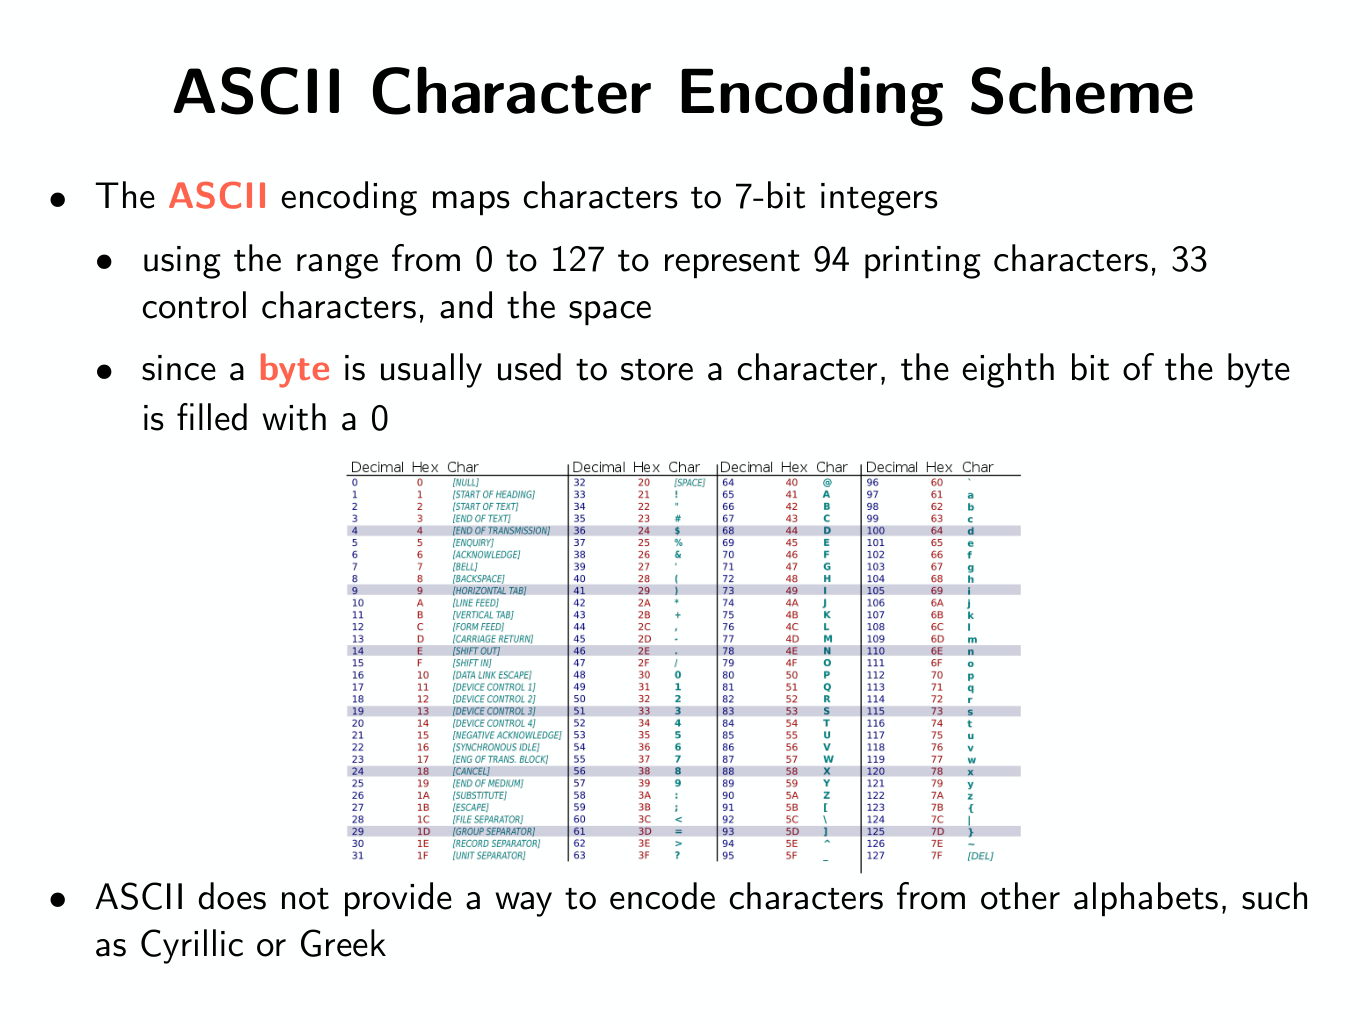

In [34]:
from huggingface_hub import hf_hub_download
from typing import Optional, List
import io
import fitz
from pathlib import Path
from PIL import Image

#filepath = hf_hub_download(repo_id="inuwamobarak/random-files", filename="2310.08535.pdf", repo_type="dataset")

images = rasterize_paper(pdf=file_name, return_pil=True, pages=page_with_formula_indexes)

print(len(images))

image = Image.open(images[0])
image


In [19]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

In [35]:
outputs = []

print(len(images))

for i in range(len(images)):

  image = Image.open(images[i])

  pixel_values = processor(images=image, return_tensors="pt").pixel_values

  outputs.append(
        model.generate(
        pixel_values.to(device),
        min_length=1,
        max_length=3584,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True,
        stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
    )
  )

print(len(outputs))

161


<ipython-input-19-1f2d56ef631f>:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  return torch.var(self.values, 1) / self.values.shape[1]


161


In [28]:
def formulas_extraction(latex_text):
  #pattern_inline_paren = r'\\\((.*?)\\\)'    # matches \( ... \)
  pattern_display_paren = r'\\\[(.*?)\\\]'   # matches \[ ... \]

  # Extract matches
  #inline_paren = re.findall(pattern_inline_paren, latex_text, flags=re.DOTALL)
  display_paren = re.findall(pattern_display_paren, latex_text, flags=re.DOTALL)

  # Combine all results into a single list
  formulas = display_paren #+ inline_paren
  return formulas


In [40]:
print(len(outputs))
print(len(page_with_formula_indexes))

161
161


In [43]:
from tkinter.constants import E
from unstructured.documents.elements import Title, NarrativeText, Image, Formula, PageBreak

cases_ok = 0
cases_under_expected = 0
cases_over_expected = 0

for i in range(len(outputs)):

  page_index = page_with_formula_indexes[i]

  generated = processor.batch_decode(outputs[i][0], skip_special_tokens=True)[0]
  generated = processor.post_process_generation(generated, fix_markdown=False)
  #print(generated)
  #print("\n")

  formulas = formulas_extraction(generated)

  num_over_expected = number_of_formulas_per_page[page_index] - len(formulas)

  if num_over_expected < 0:
    print("\nWarn: number of formulas extracted is not the number of formulas expected for the page " + str(page_index+1))
    print("Expected: " + str(number_of_formulas_per_page[page_index]))
    print("Extracted: " + str(len(formulas)))
    print(formulas)
    for j in range(number_of_formulas_per_page[page_index]):
      print(df_elements.at[locations_with_formula_at_page[page_index][j], 'Type'])
      print(df_elements.at[locations_with_formula_at_page[page_index][j], 'Value'])
    cases_under_expected += 1
  elif num_over_expected > 0:
    print("\nWarn: number of formulas extracted is more than the number of formulas expected for the page " + str(page_index+1))
    print("Expected: " + str(number_of_formulas_per_page[page_index]))
    print("Extracted: " + str(len(formulas)))
    print(formulas)
    for j in range(number_of_formulas_per_page[page_index]):
      print(df_elements.at[locations_with_formula_at_page[page_index][j], 'Type'])
      print(df_elements.at[locations_with_formula_at_page[page_index][j], 'Value'])
    cases_over_expected += 1
  else:
    cases_ok += 1

  # we have to extract number_of_formulas_per_page[i]
  #for j in range(number_of_formulas_per_page[page_index]):
    #print(df_elements.at[locations_with_formula_at_page[page_index][j], 'Value'])

    #df_elements.at[locations_with_formula_at_page[page_index][j], 'Type'] = Formula
    #df_elements.at[locations_with_formula_at_page[page_index][j], 'Value'] = formulas[j]'''

print("Cases only image: 137 (161-24)")
print("Cases ok: " + str(cases_ok))
print("Cases under expected: " + str(cases_under_expected))
print("Cases over expected: " + str(cases_over_expected))


Warn: number of formulas extracted is more than the number of formulas expected for the page 4
Expected: 1
Extracted: 0
[]
<class 'unstructured.documents.elements.Image'>
a 0 Decimal Hex Char Decimal Hex Char |Decimal Hex Char | Decimal Hex Char 0 0 [NULL] 32 20 [SPACE] | 64 40 @ 96 6 1 1 (START OF HEADING} 33 21 ! 65 41 A 97 61 a 2 2 (START OF TEXT] 34 22.2" 66 42. =B 98 62 b 3 3 (END OF TEXT} 35 23 * 67 43 c 99 63 c 4 4 [END OF TRANSMISSION] | 36 24 68 44 «=D 100 64d 5 5 {ENQUIRY} 37 25% 69 45 OE 101 65 e 6 6 (ACKNOWLEDGE) 38 26 & 70 46 F 102 66 f 7 7 (BELL 39 27! 71 47. «G 103 6&7 g 8 8 [BACKSPACE] 40 28 72 48 s4H 104 68 oh 9 9 (HORIZONTAL TAB) 41 29 =) 73 491 105 69 i 10 A [LINE FEED] 42 24 74 4a J 106 6A Oj 11 B (VERTICAL TAB] 43 2B + 75 48 K 107 6B k 12 c (FORM FEED} 44 2c , 76 4c L 108 6c 1 13 D [CARRIAGE RETURN) 45 2D =O: 77 4D M 109 6D m 14 E [SHIFT OUT) 46 2e Ct 78 4e ON 110 6E on 15 F [SHIFT IN} 47 2F 79 4F OO 111 6F oo 16 10 [DATA LINK ESCAPE} 48 30 «0 80 50 P 112 70 op 17

In [24]:
from unstructured.documents.elements import Title, NarrativeText, Image, Formula, PageBreak

# print df_elements for rows with Type Image or Formula
print(df_elements[df_elements['Type'].isin([Image, Formula])])

                                                 Type  \
16    <class 'unstructured.documents.elements.Image'>   
59    <class 'unstructured.documents.elements.Image'>   
65    <class 'unstructured.documents.elements.Image'>   
77    <class 'unstructured.documents.elements.Image'>   
138   <class 'unstructured.documents.elements.Image'>   
...                                               ...   
4460  <class 'unstructured.documents.elements.Image'>   
4461  <class 'unstructured.documents.elements.Image'>   
4462  <class 'unstructured.documents.elements.Image'>   
4463  <class 'unstructured.documents.elements.Image'>   
4464  <class 'unstructured.documents.elements.Image'>   

                                                  Value  
16    a 0 Decimal Hex Char Decimal Hex Char |Decimal...  
59    Oxxxxxxx 110xxxxx 10xxxxxx 1110xxxx 10Oxxxxxx ...  
65    Number of Number of bits in Code Bytes Point R...  
77    Number of Number of bits in Code Bytes Point R...  
138                      